In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## Bahdanau Attention based


In [2]:
class AttentionDecoder(d2l.Decoder):  # @save
    """The base attention-based decoder for interface"""

    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

**Sequence-to-Sequence Attention Decoder**

Here we init the state of the decoder as follows

1. The hidden states of the last layer of the encoder at all steps, is used as _keys_ and _values_ (h_t)

2. The hidden state of the encoder at all layers at the final time steps serves to init the decoder

3. The valid length (`valid_lens`) of the encoder to ignore the padding tokens

At each decoding timestep, the hidden state of the final layer of the decoder (s) obtained previous time step, is used as the query of the attention mechanism


In [3]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout
        )
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Unsqueeze adds a new dimension of size 1 in hidden_state
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

**Testing**


In [4]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = d2l.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens, num_layers)


X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
d2l.check_shape(output, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[0], (batch_size, num_steps, num_hiddens))
d2l.check_shape(state[1][0], (batch_size, num_hiddens))

/home/sih/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


**Training**


In [5]:
@d2l.add_to_class(d2l.MTFraEng)
def _download(self):
    """Since I downloaded it manually"""
    # d2l.extract(d2l.download(
    #     d2l.DATA_URL+'fra-eng.zip', self.root,
    #     '94646ad1522d915e7b0f9296181140edcf86a4f5'))
    with open(self.root + "/fra-eng/fra.txt", encoding="utf-8") as f:
        return f.read()

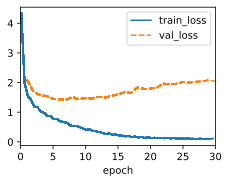

In [6]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(
len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [7]:
# Testing using BLEU metric

engs = ["go .", "i lost .", "he's calm .", "i'm home ."]
fras = ["va !", "j'ai perdu .", "il est calme .", "je suis chez moi ."]
preds, _ = model.predict_step(data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == "<eos>":
            break
        translation.append(token)
    print(
        f"{en} => {translation}, bleu,"
        f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}'
    )

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['nous', '<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


In [8]:
# We now verify the attention weights when translating the last english sentence and see that each query assigns non
# uniform weights over the key-value pairs. It shows that at each decoding step, different
# parts of the input sequencs are selectively aggregated in the attention pooling
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True
)
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

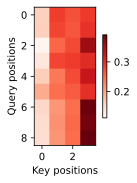

In [11]:
# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, : len(engs[-1].split()) + 1].cpu(),
    xlabel="Key positions",
    ylabel="Query positions",
)